# Purpose of the Code

The goal of this notebook is to perform feature selection and evaluate the performance of various machine learning models, identifying the optimal combination of features and models to improve predictive performance and reduce model complexity.

## Environment Setup

In [1]:
# pip install libemg  # Required only if you have never installed the libemg package
# pip install --upgrade paramiko cryptography  # Needed during first-time installation of libemg to resolve dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from libemg.feature_selector import FeatureSelector
sys.path.append('../lib')
from fs_utils import (plot_label_distribution, balance_via_undersampling, plot_feature_vs_label, plot_feature_correlation,
                        drop_highly_correlated_features, report_remaining_high_correlations, prepare_cv_data, plot_feature_accuracy,
                        plot_sequential_selection_heatmap, plot_feature_selection_performance, evaluate_feature_subsets, plot_pca_variance)
from me_utils import evaluate_emg_classifier

In [33]:
# Parameters
device = "trigno"  # Devices: "trigno" or "myo"
date = "05_14"     # Recording date in MM_DD format
subject = "01"     # Subject ID, e.g., "01", "02", etc.
preferred_features = ['MAV', 'SSC', 'WL'] # List of preferred EMG features for selection
labels = ['no weight', 'light', 'medium', 'heavy'] # List of possible labels
label_map = {'no weight': 0, 'light': 1, 'medium': 2, 'heavy': 3} # Map string labels to integers for modeling
metric = "accuracy" # Metric used during feature selection, possible choice 
                    # between "accuracy", "activeerror", "meansemiprincipalaxis", "featureefficiency", "repeatability", "seperability"
n_folds = 5 # Number of folds to use for cross-validation for feature selection
th = 0.8 # Threshold for features with correlation
fs = FeatureSelector() # Initialize FeatureSelector object for feature selection tasks
scaler = StandardScaler() # Initialize StandardScaler object
results = {}  # Dictionary to store results scores keyed by model name

# Initialize variables based on device
if device == 'trigno':
    suffixes = ['_biceps', '_triceps', '_forearm1', '_forearm2']
    bins = [0, 0.02, 0.07, 0.15, np.inf]
    labels_MAV = ['0-2', '2-7', '7-15', '15+']
    ref_feature = "MAV_biceps"
elif device == 'myo':
    suffixes = ['_channel_1', '_channel_2', '_channel_3', '_channel_4',
                '_channel_5', '_channel_6', '_channel_7', '_channel_8']
    bins = [0, 0.10, 0.27, 0.47, np.inf]
    labels_MAV = ['0-0.10', '0.10-0.27', '0.27-0.47', '0.47+']
    ref_feature = "MAV_channel_6"

# Paths for input and output
input_folder = f'../data/extracted_features/{device}/S{subject}_{date}/'  # Input folder with raw data

# Loading Data Files

In [4]:
csv_files = [file for file in os.listdir(input_folder) if file.endswith('.csv')]
df = pd.read_csv(os.path.join(input_folder, csv_files[0])) # Read the first CSV file in the list into a DataFrame
df.head()

,IAV_biceps,ISD_biceps,KURT_biceps,LD_biceps,MAV_biceps,MNF_biceps,MNP_biceps,MPK_biceps,RMS_biceps,SAMPEN_biceps,...,RMS_triceps,SAMPEN_triceps,SKEW_triceps,SM_triceps,SSC_triceps,VAR_triceps,WAMP_triceps,WL_triceps,ZC_triceps,label
0,1.736563,0.008704,3.304863,1.004509,0.004511,1.335065,9.845841e-08,0.007109,0.004755,0.000118,...,0.033689,0.000118,0.488448,0.204032,67,2.765726e-04,155,0.057460,25,no weight
1,2.445613,0.015762,2.888070,1.006352,0.006352,0.902709,1.851457e-07,0.007109,0.006398,0.007901,...,0.049810,0.010545,0.417209,0.210026,75,6.686829e-05,163,0.035517,27,no weight
2,2.573876,0.017231,3.084319,1.006685,0.006685,1.055315,2.035408e-07,0.007109,0.006690,0.000118,...,0.051392,0.000118,0.253653,0.321649,83,1.559642e-05,145,0.013610,31,no weight
3,2.479283,0.015971,2.900808,1.006440,0.006440,1.098310,1.887411e-07,0.006685,0.006441,0.026430,...,0.046416,0.007497,0.377234,0.282521,84,4.147747e-06,139,0.007912,33,no weight
4,2.524974,0.016572,2.774688,1.006558,0.006558,1.054011,1.958086e-07,0.006863,0.006561,0.000201,...,0.045440,0.000201,0.341720,0.249096,73,3.795827e-07,141,0.002154,34,no weight


In [5]:
df.info(max_cols=10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9727 entries, 0 to 9726
Columns: 69 entries, IAV_biceps to label
dtypes: float64(56), int64(12), object(1)
memory usage: 5.1+ MB


In [6]:
train_df, test_df = train_test_split(df, test_size=0.30, random_state=42) # Split into train (70%) and test (30%)
print("Train set:", train_df.shape)
print("Test set:", test_df.shape)

Train set: (6808, 69)
Test set: (2919, 69)


# Exploratory Data Analysis (EDA)

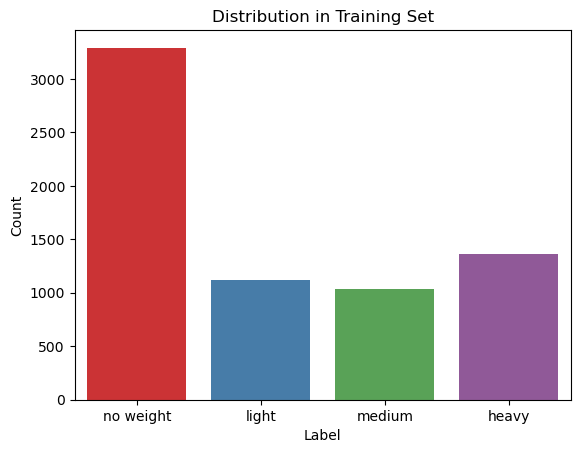

In [7]:
plot_label_distribution(train_df, labels, title='Distribution in Training Set') # Plot train set distribution

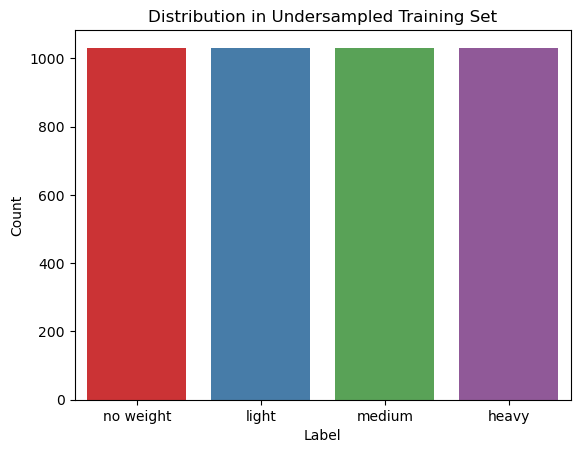

In [8]:
# Check class distribution counts
counts = train_df['label'].value_counts()
min_count = counts.min()
max_count = counts.max()

if max_count != min_count:
    train_df = balance_via_undersampling(train_df, label_col='label')
    plot_label_distribution(train_df, labels, title='Distribution in Undersampled Training Set')
else:
    print("Classes are already balanced. No undersampling performed.")

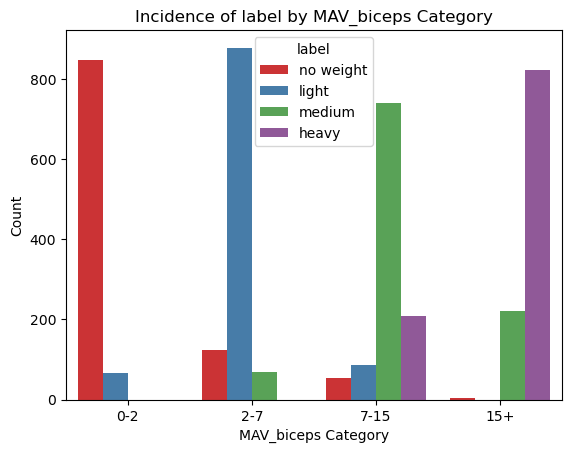

In [9]:
# Example: Correlation label-feature (MAV)
plot_feature_vs_label(train_df, ref_feature, bins, labels_MAV)

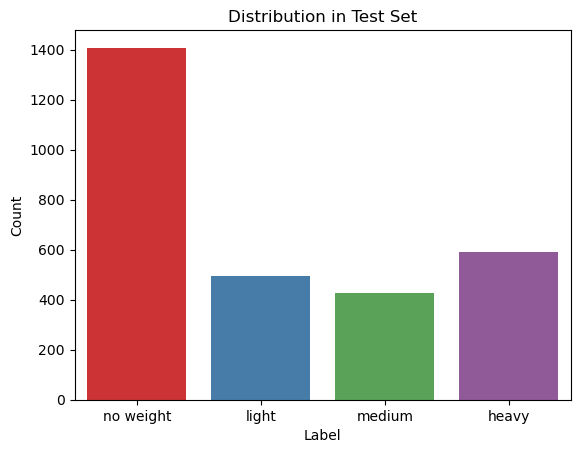

In [10]:
plot_label_distribution(test_df, labels, title='Distribution in Test Set') # Plot test set distribution

# Feature Engineering

## Feature Correlation Selection

In [35]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
y = y_train.map(label_map)  # Convert label strings to numeric values using label_map  
X = scaler.fit_transform(X_train) # Scale features to zero mean and unit variance to normalize data
X = pd.DataFrame(X, columns=X_train.columns, index=X_train.index) # Scaled dataframe with column names

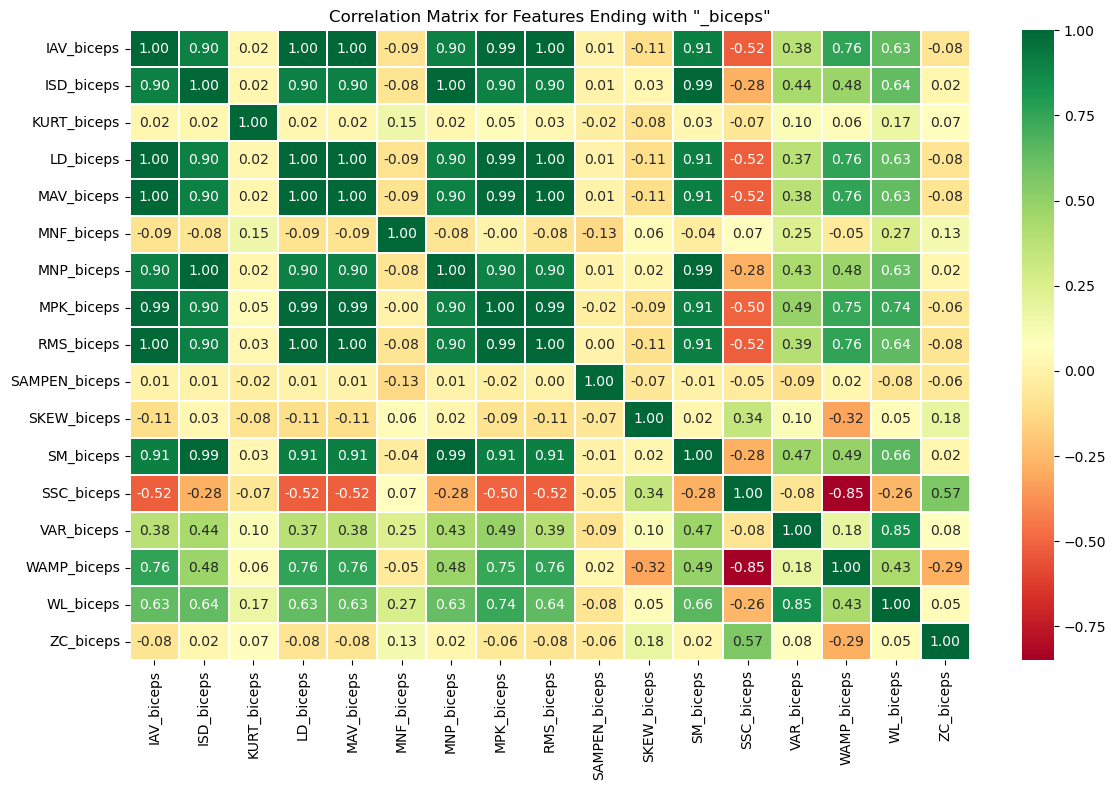

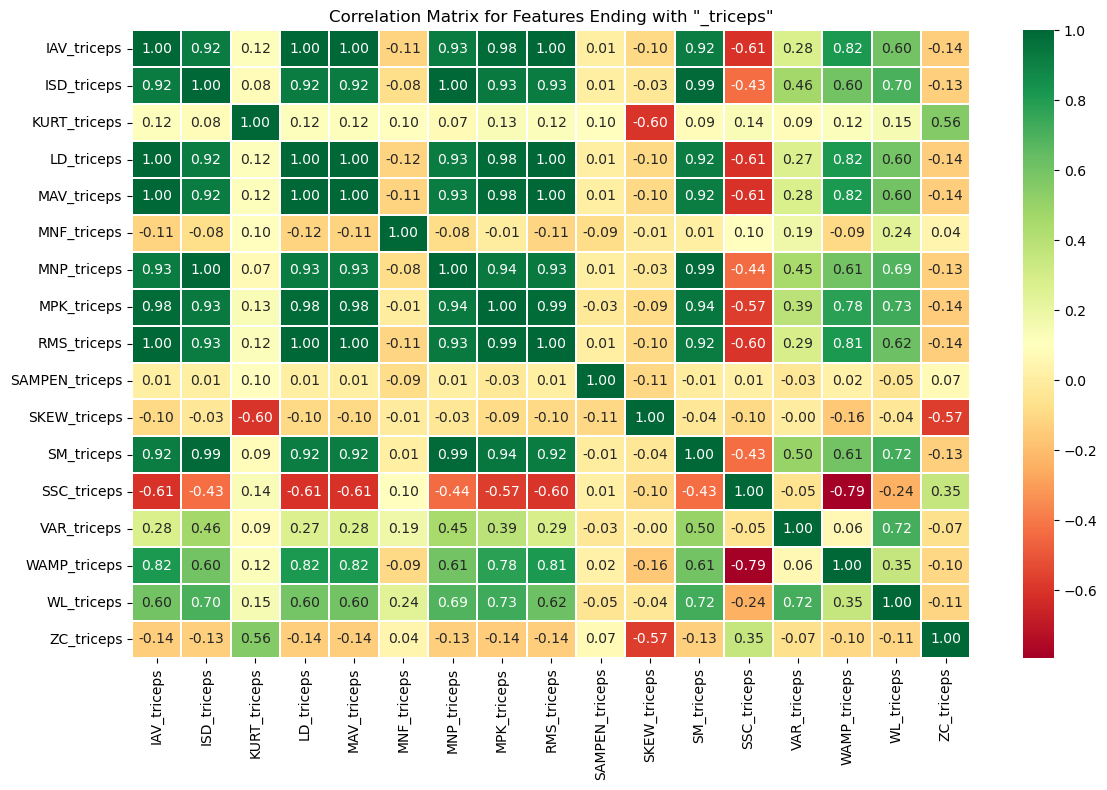

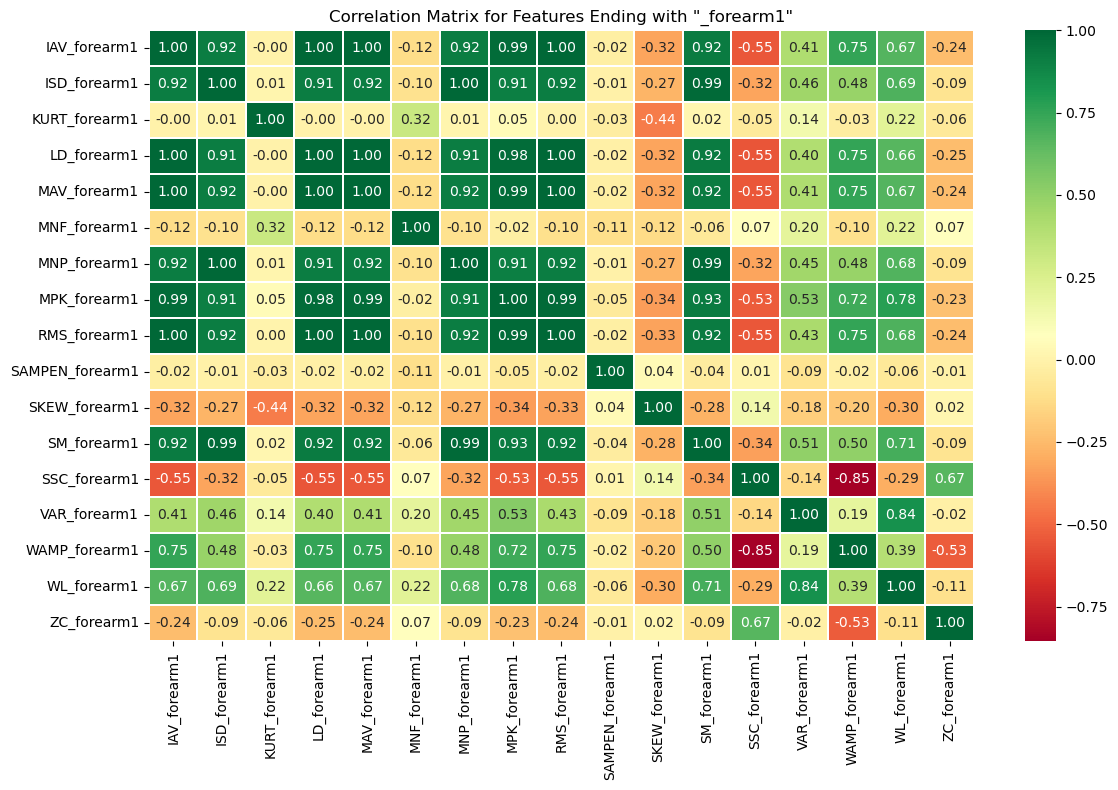

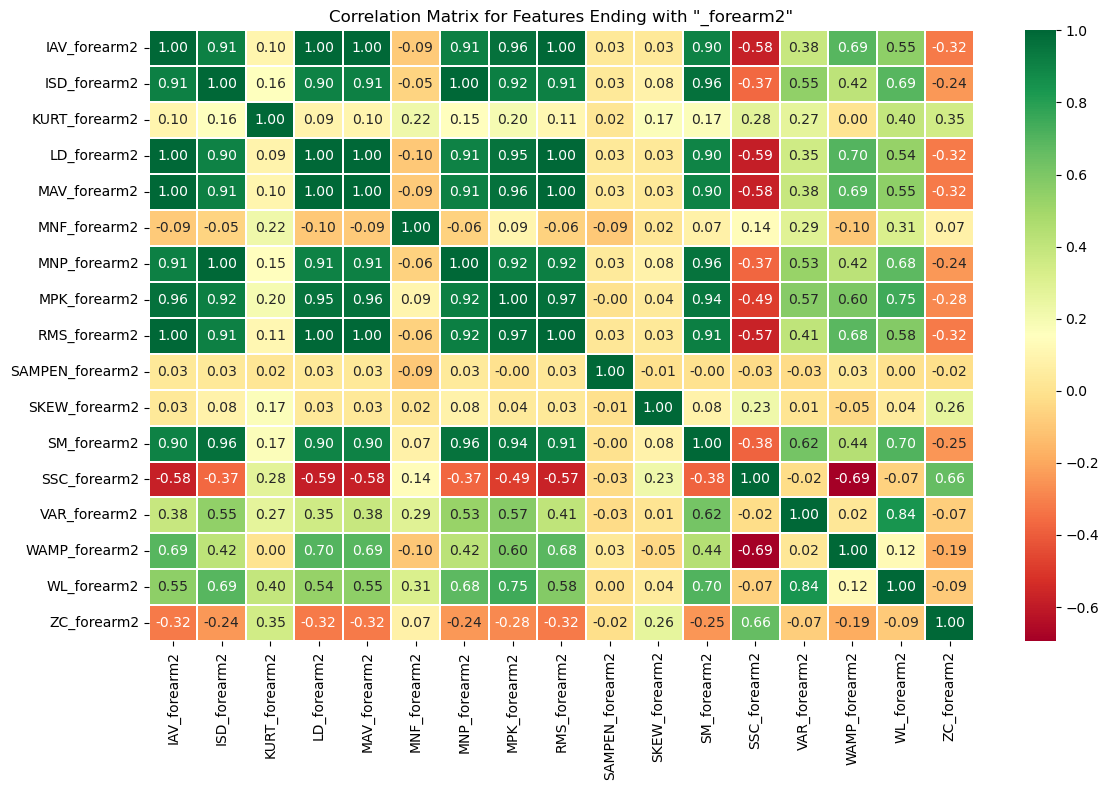

In [12]:
plot_feature_correlation(X, suffixes) # Plot correlation matrices for groups of features (each muscle/channel)

In [13]:
# Drop redundant features within each muscle group, keeping only preferred ones
X_red = drop_highly_correlated_features(X, suffixes, preferred_features, th)
print(f"Total remaining features: {len(X_red.columns)}")

Total remaining features: 34


In [14]:
report_remaining_high_correlations(X_red, suffixes, th)

Remaining highly correlated features (>0.8 intra-channel, >0.9 inter-channel) after filtering:
No high correlations found in the dataset above thresholds.


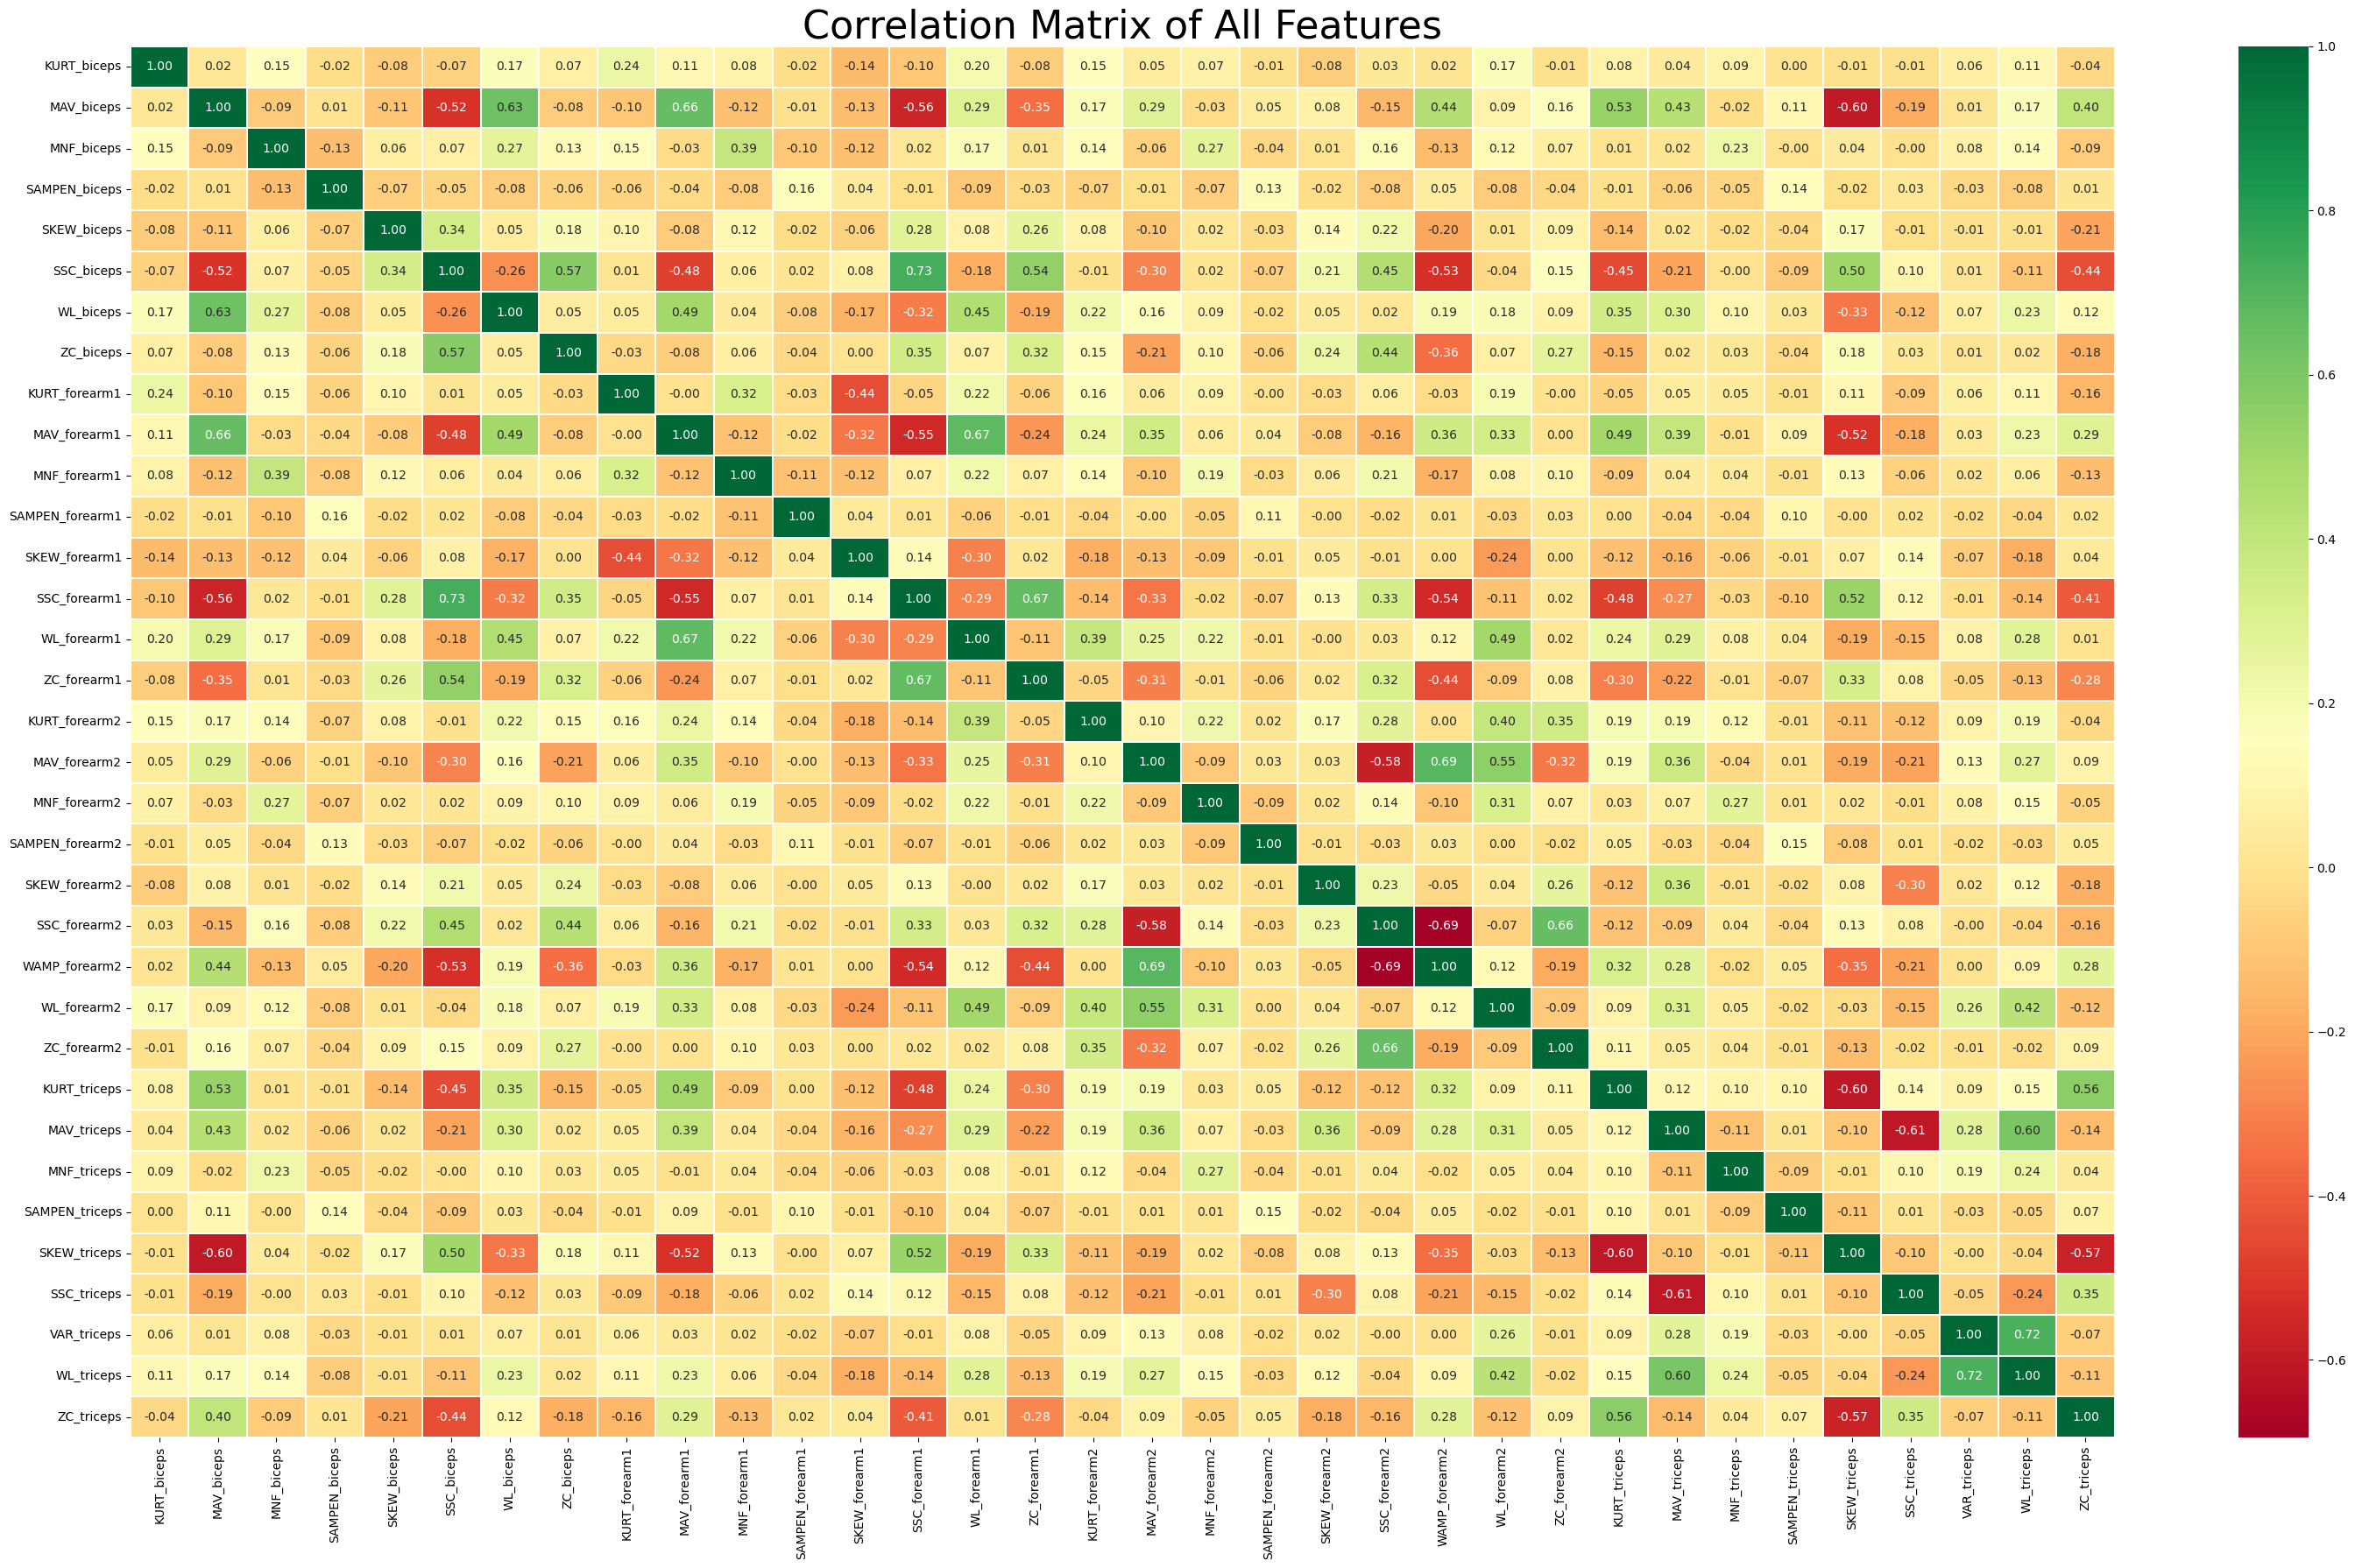

In [15]:
plot_feature_correlation(X_red, all_features=True) # Plot overall correlation matrix for all remaining features

## Feature Wrapping Selection

In [16]:
crossvalidation_var, data_dict = prepare_cv_data(X_red, n_folds, random_state=42) # Prepare cross-validation fold labels and dict for feature selection
accuracy_results, accuracy_fs = fs.run_selection(data_dict, metric, y, crossvalidation_var) # Run feature selection

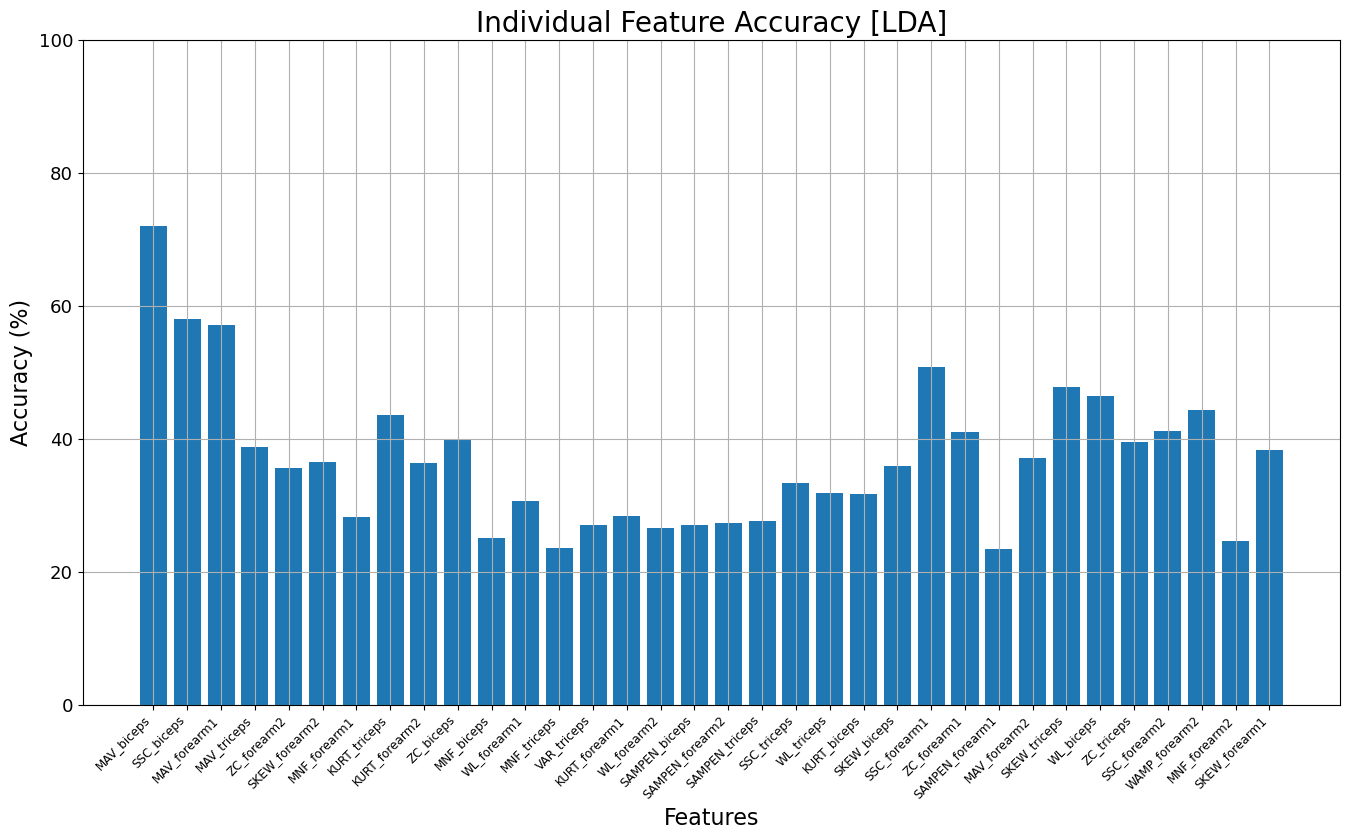

In [17]:
plot_feature_accuracy(accuracy_fs, accuracy_results[0])

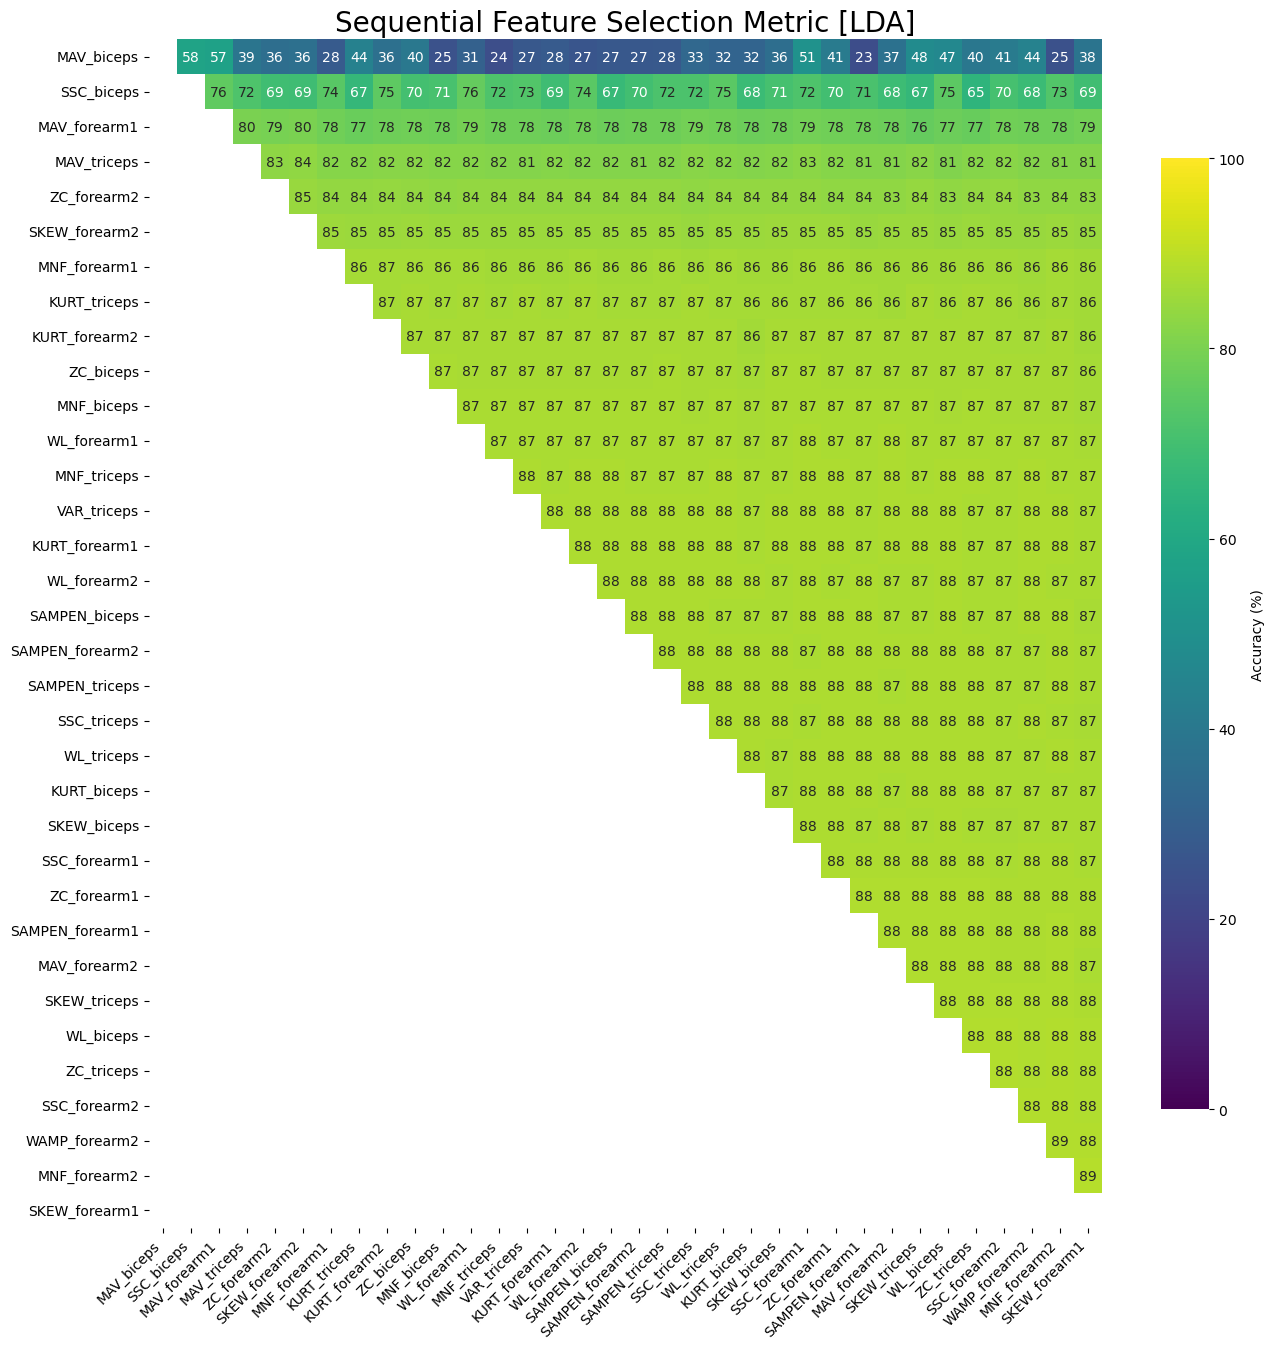

In [18]:
plot_sequential_selection_heatmap(accuracy_results, accuracy_fs)

In [19]:
# res = evaluate_feature_subsets(X_red, y, accuracy_fs, n_folds) # Evaluate model accuracy across increasing feature subset sizes (Random Forest)

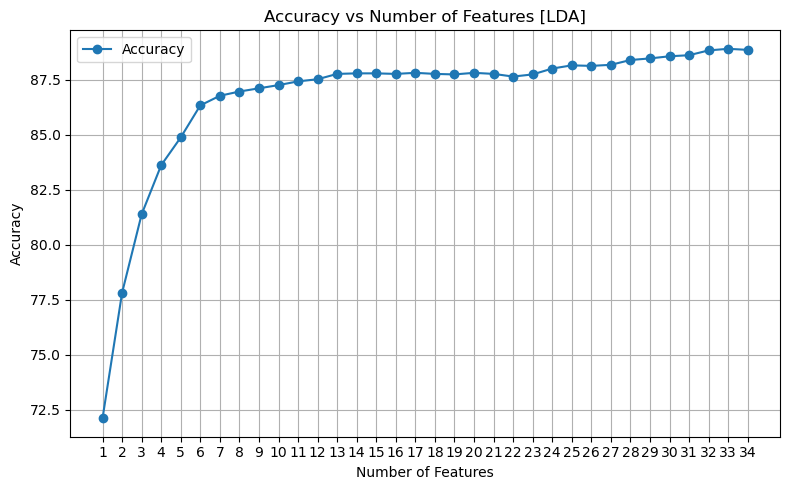

In [20]:
res = list(zip(range(1, len(np.diag(accuracy_results)) + 1), np.diag(accuracy_results)))
plot_feature_selection_performance(res, "LDA") # Plot accuracy to assess performance trends

## Principal Component Analysis (PCA)

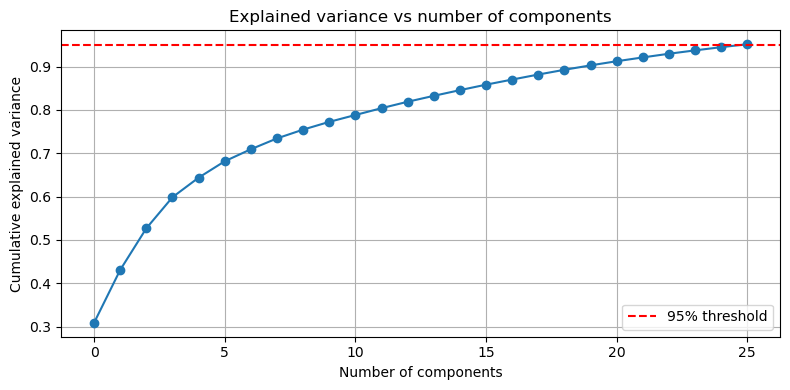

In [36]:
pca = PCA(n_components=0.95)  # Keep the number of components that explain 95% of the variance
X_pca = pca.fit_transform(X)  # Fit PCA on X and transform it to the reduced component space
plot_pca_variance(pca)        # Plot cumulative explained variance to visualize component contribution

# Model Evaluation

## Model Training

In [37]:
# Feature Set Preparation
X_test = test_df.drop(columns=['label'])
X_test = scaler.transform(X_test) # Apply same scaling used on training data to test set
X_test = pd.DataFrame(X_test, columns=X.columns) # Scaled dataframe with column names
y_test = test_df['label']
selected_columns = accuracy_fs[:13]  # Wrapping Selection

X_train1 = X # Original feature set (no reduction or selection)
X_train2 = X_red # Reduced feature set (e.g., after removing highly correlated features)
X_train3 = X[selected_columns] # Wrapping selected feature set
X_train4 = X_pca # PCA feature set 

X_test1 = X_test 
X_test2 = X_test[X_red.columns]
X_test3 = X_test[selected_columns] 
X_test4 = pca.transform(X_test) 

feature_sets_train = [X_train1, X_train2, X_train3, X_train4]
feature_sets_test = [X_test1, X_test2, X_test3, X_test4]

y_train = y # Train label array
y_test = y_test.map(label_map)  # Convert label strings to numeric values using label_map  

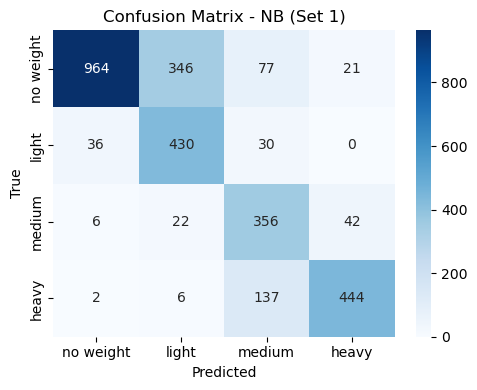

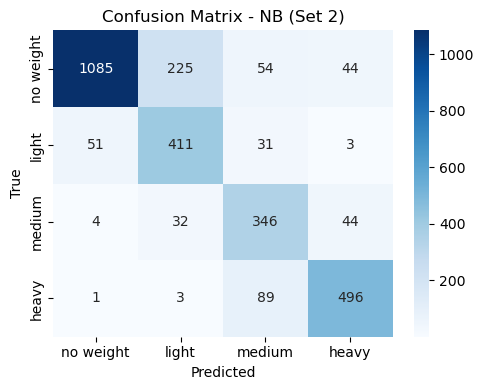

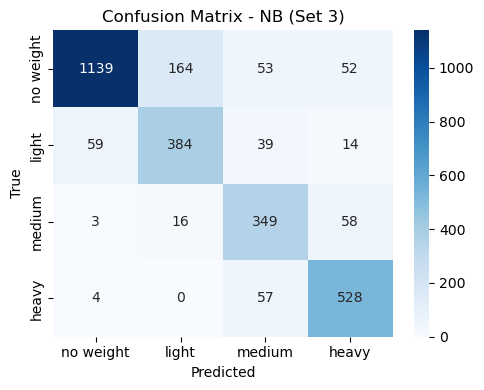

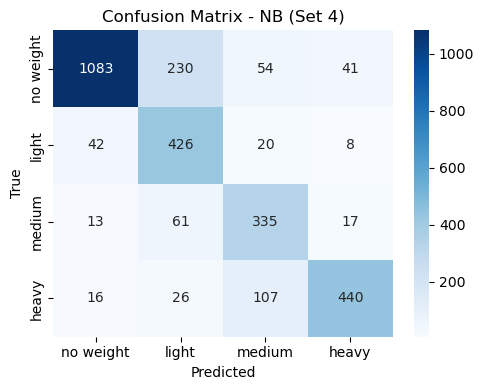

-------- NB Classifier - Evaluation Metrics --------
Accuracy: Set 1: 75.16% | Set 2: 80.10% | Set 3: 82.22% | Set 4: 78.25%
Precision: Set 1: 81.55% | Set 2: 83.04% | Set 3: 83.73% | Set 4: 82.03%
Recall: Set 1: 75.16% | Set 2: 80.10% | Set 3: 82.22% | Set 4: 78.25%
F1: Set 1: 76.21% | Set 2: 80.73% | Set 3: 82.56% | Set 4: 79.06%
Time: Set 1: 48 ms | Set 2: 18 ms | Set 3: 42 ms | Set 4: 11 ms


In [38]:
#################################### Naive Bayes ########################
model_name = 'NB'  
results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    acc, precision, recall, f1, proc_time = evaluate_emg_classifier(X_tr, y_train, X_te, y_test, model_name=model_name, set_index=i)
    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(proc_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

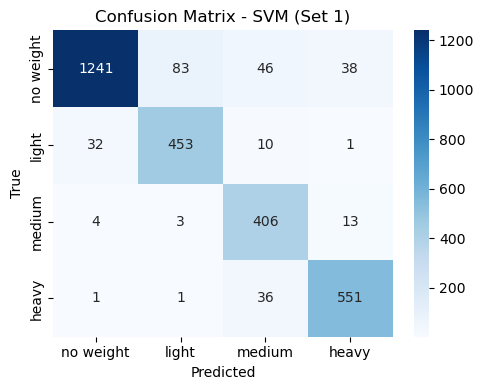

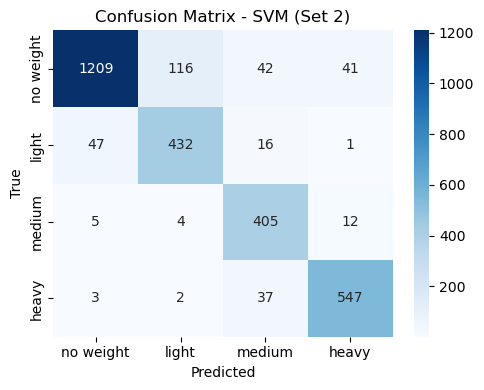

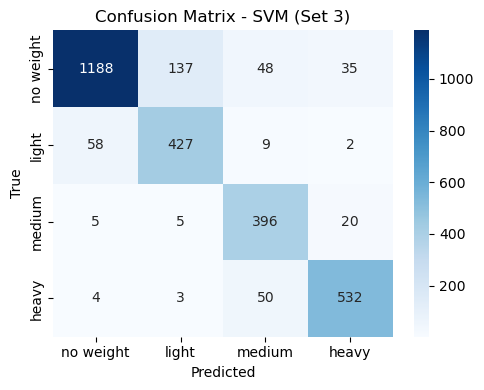

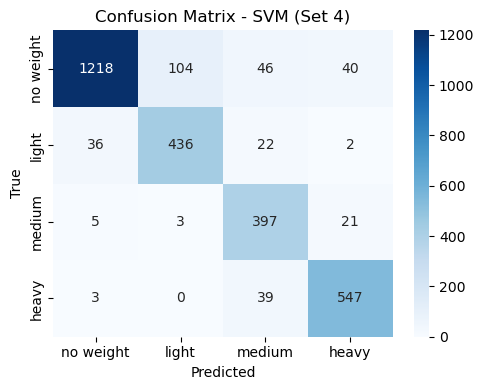

-------- SVM Classifier - Evaluation Metrics --------
Accuracy: Set 1: 90.82% | Set 2: 88.83% | Set 3: 87.12% | Set 4: 89.00%
Precision: Set 1: 91.43% | Set 2: 89.57% | Set 3: 88.06% | Set 4: 89.79%
Recall: Set 1: 90.82% | Set 2: 88.83% | Set 3: 87.12% | Set 4: 89.00%
F1: Set 1: 90.91% | Set 2: 88.95% | Set 3: 87.29% | Set 4: 89.14%
Time: Set 1: 3242 ms | Set 2: 2713 ms | Set 3: 1536 ms | Set 4: 2550 ms


In [39]:
#################################### SVM ########################
model_name = 'SVM'  
results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    acc, precision, recall, f1, proc_time = evaluate_emg_classifier(X_tr, y_train, X_te, y_test, model_name=model_name, set_index=i)
    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(proc_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

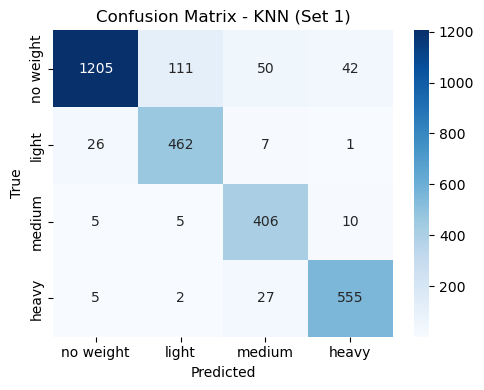

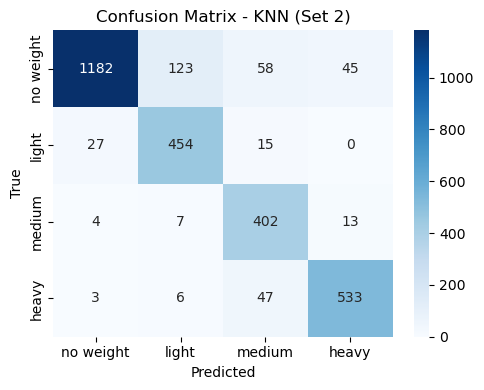

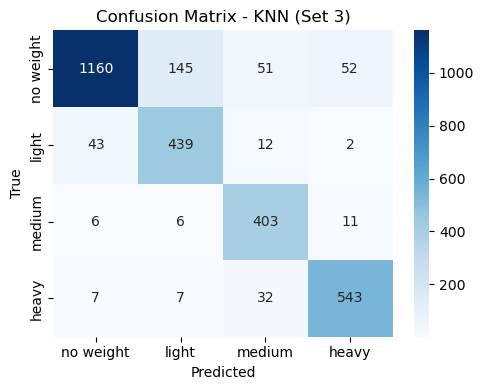

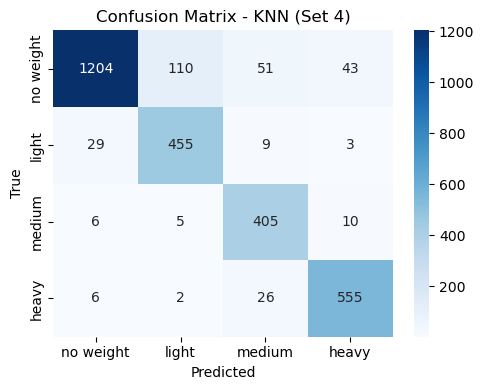

-------- KNN Classifier - Evaluation Metrics --------
Accuracy: Set 1: 90.03% | Set 2: 88.08% | Set 3: 87.19% | Set 4: 89.72%
Precision: Set 1: 90.88% | Set 2: 89.40% | Set 3: 88.34% | Set 4: 90.53%
Recall: Set 1: 90.03% | Set 2: 88.08% | Set 3: 87.19% | Set 4: 89.72%
F1: Set 1: 90.12% | Set 2: 88.27% | Set 3: 87.33% | Set 4: 89.82%
Time: Set 1: 76 ms | Set 2: 88 ms | Set 3: 299 ms | Set 4: 56 ms


In [40]:
#################################### KNN ########################
model_name = 'KNN'  
results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    acc, precision, recall, f1, proc_time = evaluate_emg_classifier(X_tr, y_train, X_te, y_test, model_name=model_name, set_index=i)
    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(proc_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

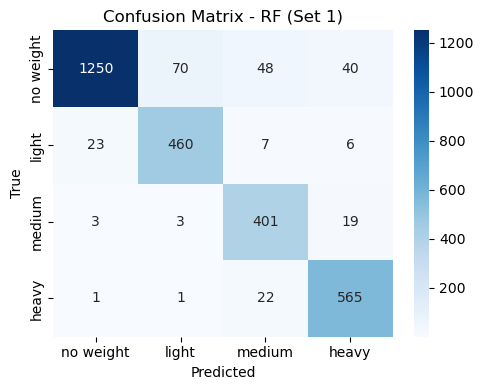

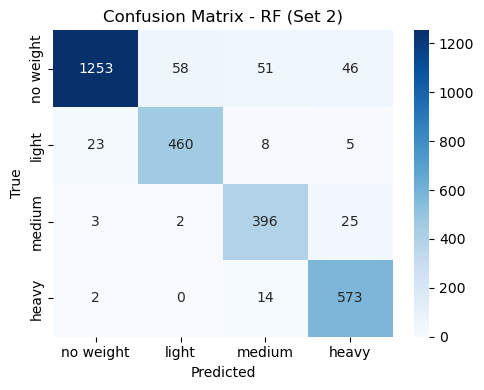

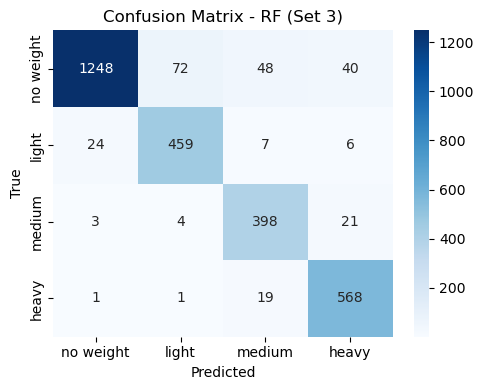

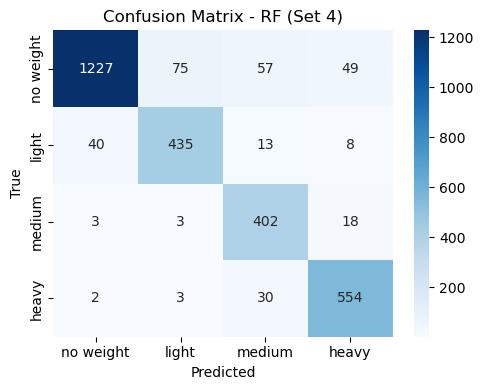

-------- RF Classifier - Evaluation Metrics --------
Accuracy: Set 1: 91.68% | Set 2: 91.88% | Set 3: 91.57% | Set 4: 89.69%
Precision: Set 1: 92.19% | Set 2: 92.35% | Set 3: 92.08% | Set 4: 90.31%
Recall: Set 1: 91.68% | Set 2: 91.88% | Set 3: 91.57% | Set 4: 89.69%
F1: Set 1: 91.74% | Set 2: 91.93% | Set 3: 91.64% | Set 4: 89.78%
Time: Set 1: 13310 ms | Set 2: 8616 ms | Set 3: 6149 ms | Set 4: 9513 ms


In [41]:
#################################### Random Forest ########################
model_name = 'RF'  
rf_params = {'n_estimators': 800, 'min_samples_split': 12, 'max_features': 'sqrt', 'oob_score': True, 'random_state': 1, 'n_jobs': -1}

results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    acc, precision, recall, f1, proc_time = evaluate_emg_classifier(X_tr, y_train, X_te, y_test, model_params=rf_params, 
                                                                    model_name=model_name, set_index=i)
    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(proc_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

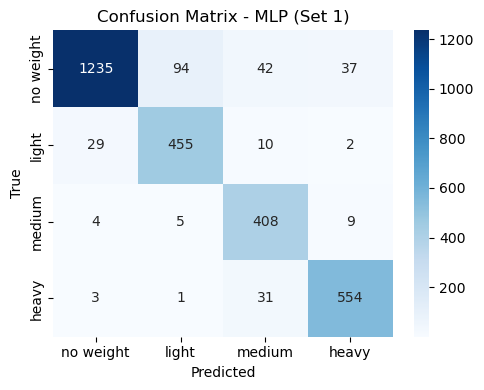

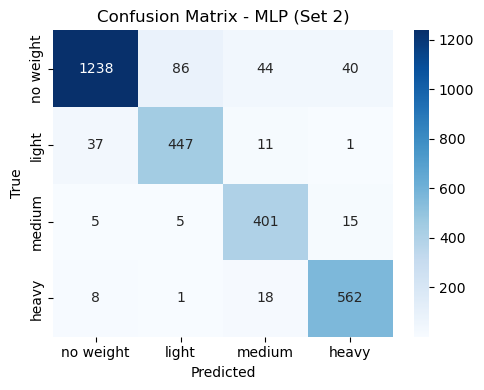

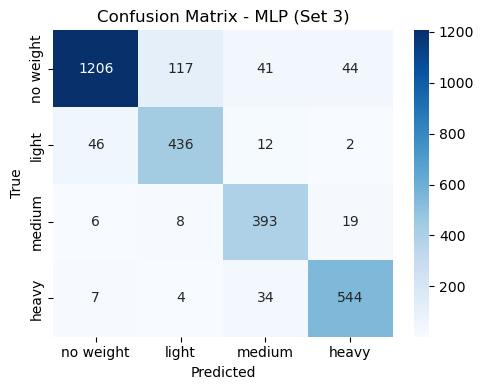

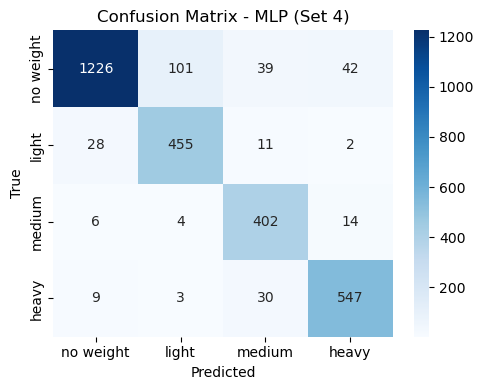

-------- MLP Classifier - Evaluation Metrics --------
Accuracy: Set 1: 90.85% | Set 2: 90.72% | Set 3: 88.35% | Set 4: 90.10%
Precision: Set 1: 91.50% | Set 2: 91.15% | Set 3: 89.07% | Set 4: 90.75%
Recall: Set 1: 90.85% | Set 2: 90.72% | Set 3: 88.35% | Set 4: 90.10%
F1: Set 1: 90.94% | Set 2: 90.77% | Set 3: 88.48% | Set 4: 90.19%
Time: Set 1: 1387 ms | Set 2: 1362 ms | Set 3: 1193 ms | Set 4: 1599 ms


In [42]:
#################################### Neural Network ########################
model_name = 'MLP'  
mlp_params ={ 'hidden_layer_sizes': (50, 30), 'activation': 'relu', 'solver': 'adam', 'max_iter': 200, 'early_stopping': True, 'random_state': 42}
results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    acc, precision, recall, f1, proc_time = evaluate_emg_classifier(X_tr, y_train, X_te, y_test, model_params=mlp_params, 
                                                                    model_name=model_name, set_index=i)
    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(proc_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

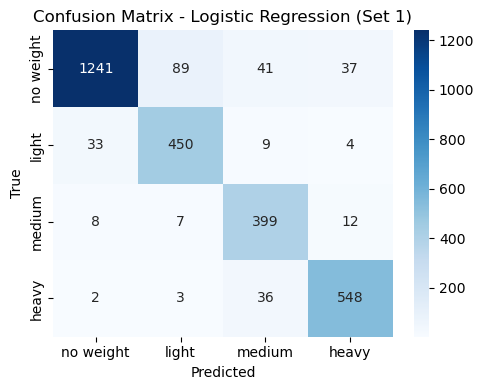

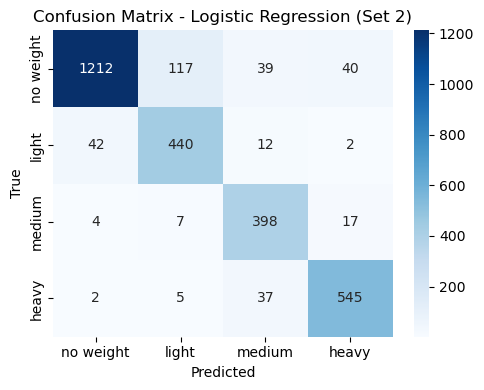

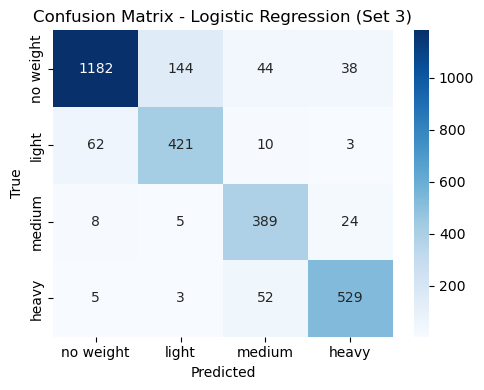

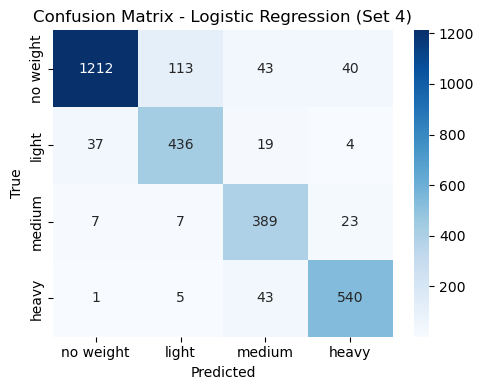

-------- Logistic Regression Classifier - Evaluation Metrics --------
Accuracy: Set 1: 90.37% | Set 2: 88.90% | Set 3: 86.37% | Set 4: 88.28%
Precision: Set 1: 90.95% | Set 2: 89.70% | Set 3: 87.28% | Set 4: 89.16%
Recall: Set 1: 90.37% | Set 2: 88.90% | Set 3: 86.37% | Set 4: 88.28%
F1: Set 1: 90.48% | Set 2: 89.04% | Set 3: 86.55% | Set 4: 88.45%
Time: Set 1: 233 ms | Set 2: 68 ms | Set 3: 53 ms | Set 4: 121 ms


In [43]:
#################################### Logistic Regression ########################
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

model_name = 'Logistic Regression'
lr_params = {'max_iter': 1000} 

results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    # Inizializza il modello
    model = LogisticRegression(**lr_params)
    
    # Start timing
    start_time = time.time()
    
    # Addestra il modello
    model.fit(X_tr, y_train)
    
    # Predici
    preds = model.predict(X_te)
    
    # Fine timing
    end_time = time.time()
    processing_time = (end_time - start_time) * 1000  # ms
    
    # Matrice di confusione
    cm = confusion_matrix(y_test, preds)
    class_names = ['no weight', 'light', 'medium', 'heavy']
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    title = f'Confusion Matrix - {model_name} (Set {i})'
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # Metriche
    acc = accuracy_score(y_test, preds) * 100
    precision = precision_score(y_test, preds, average='weighted', zero_division=0) * 100
    recall = recall_score(y_test, preds, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0) * 100
    
    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(processing_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

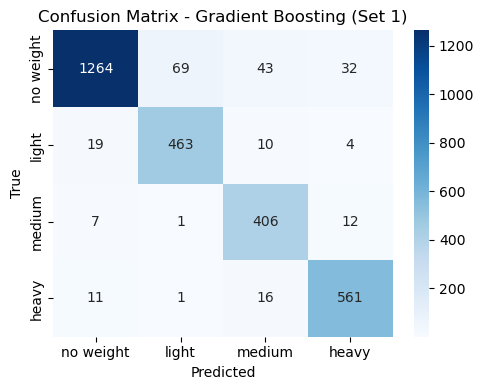

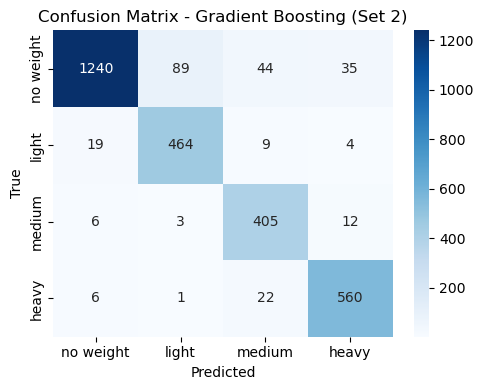

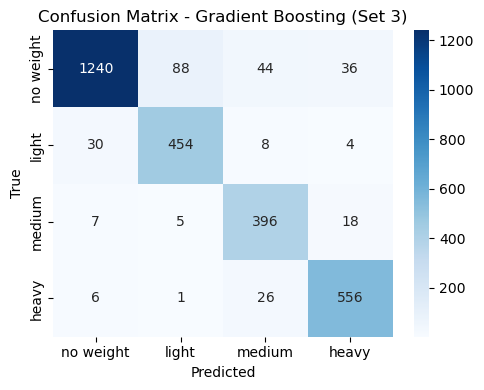

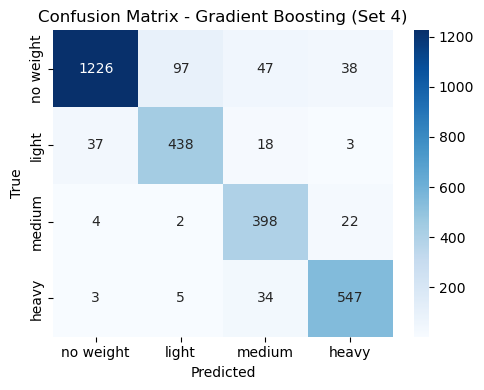

-------- Gradient Boosting Classifier - Evaluation Metrics --------
Accuracy: Set 1: 92.29% | Set 2: 91.44% | Set 3: 90.65% | Set 4: 89.38%
Precision: Set 1: 92.66% | Set 2: 92.02% | Set 3: 91.16% | Set 4: 90.08%
Recall: Set 1: 92.29% | Set 2: 91.44% | Set 3: 90.65% | Set 4: 89.38%
F1: Set 1: 92.34% | Set 2: 91.51% | Set 3: 90.73% | Set 4: 89.50%
Time: Set 1: 64877 ms | Set 2: 28844 ms | Set 3: 11828 ms | Set 4: 27223 ms


In [44]:
#################################### Gradient Boosting ########################
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

model_name = 'Gradient Boosting'
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
}

results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    # Inizializza il modello con i parametri
    model = GradientBoostingClassifier(**gb_params)
    
    # Start timing
    start_time = time.time()
    
    # Addestra il modello
    model.fit(X_tr, y_train)
    
    # Predici
    preds = model.predict(X_te)
    
    # Fine timing
    end_time = time.time()
    processing_time = (end_time - start_time) * 1000  # in ms
    
    # Matrice di confusione
    cm = confusion_matrix(y_test, preds)
    class_names = ['no weight', 'light', 'medium', 'heavy']
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    title = f'Confusion Matrix - {model_name} (Set {i})'
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # Calcolo metriche
    acc = accuracy_score(y_test, preds) * 100
    precision = precision_score(y_test, preds, average='weighted', zero_division=0) * 100
    recall = recall_score(y_test, preds, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0) * 100
    
    # Salva risultati
    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(processing_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

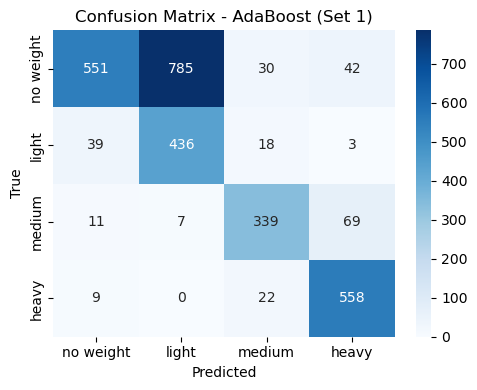

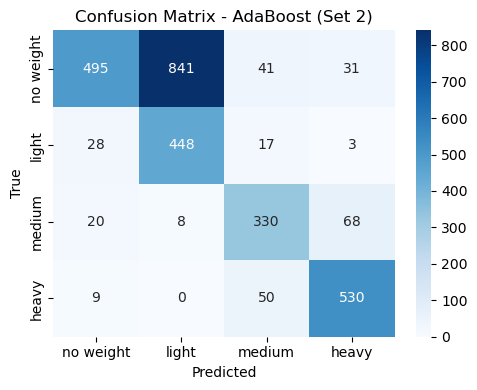

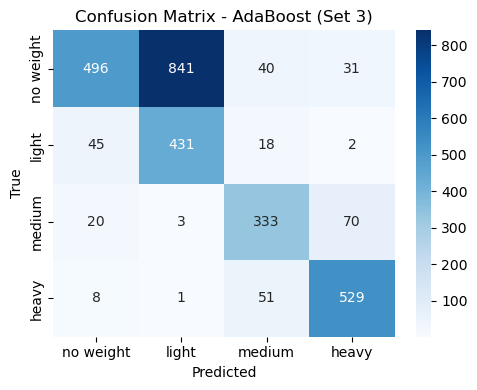

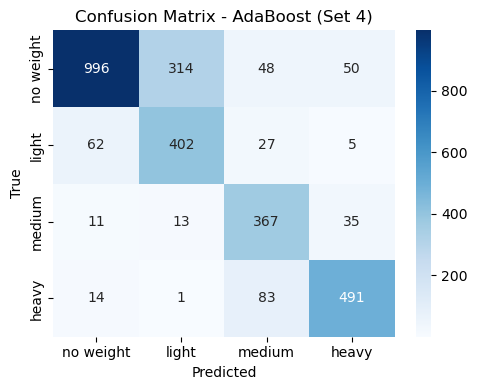

-------- AdaBoost Classifier - Evaluation Metrics --------
Accuracy: Set 1: 64.54% | Set 2: 61.77% | Set 3: 61.29% | Set 4: 77.29%
Precision: Set 1: 78.45% | Set 2: 77.04% | Set 3: 75.67% | Set 4: 80.97%
Recall: Set 1: 64.54% | Set 2: 61.77% | Set 3: 61.29% | Set 4: 77.29%
F1: Set 1: 64.64% | Set 2: 61.52% | Set 3: 61.15% | Set 4: 77.92%
Time: Set 1: 6066 ms | Set 2: 3050 ms | Set 3: 1482 ms | Set 4: 3000 ms


In [45]:
#################################### ADA Boost ########################
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

model_name = 'AdaBoost'
ada_params = {
    'n_estimators': 100,
    'learning_rate': 1.0,
    'algorithm': 'SAMME',
    'random_state': 42
}

results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}

for i, (X_tr, X_te) in enumerate(zip(feature_sets_train, feature_sets_test), start=1):
    model = AdaBoostClassifier(**ada_params)

    start_time = time.time()
    model.fit(X_tr, y_train)
    preds = model.predict(X_te)
    end_time = time.time()
    processing_time = (end_time - start_time) * 1000  # in ms

    cm = confusion_matrix(y_test, preds)
    class_names = ['no weight', 'light', 'medium', 'heavy']
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    title = f'Confusion Matrix - {model_name} (Set {i})'
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_test, preds) * 100
    precision = precision_score(y_test, preds, average='weighted', zero_division=0) * 100
    recall = recall_score(y_test, preds, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0) * 100

    results[model_name]['accuracy'].append(acc)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['time'].append(processing_time)

print(f'-------- {model_name} Classifier - Evaluation Metrics --------')
for metric_name, values in results[model_name].items():
    values_str = ' | '.join([
        f'Set {i}: {v:.2f}%' if metric_name != 'time' else f'Set {i}: {v:.0f} ms'
        for i, v in enumerate(values, start=1)
    ])
    print(f'{metric_name.capitalize()}: {values_str}')

In [47]:
import pandas as pd

metriche = ['accuracy', 'precision', 'recall', 'f1', 'time']
model_names = list(results.keys())
n_sets = len(next(iter(results.values()))['accuracy'])

for i in range(n_sets):
    rows = []
    for model in model_names:
        r = results[model]
        row = {
            'Model': model,
            'Accuracy': round(r['accuracy'][i], 2),
            'Precision': round(r['precision'][i], 2),
            'Recall': round(r['recall'][i], 2),
            'F1': round(r['f1'][i], 2),
            'Time (ms)': round(r['time'][i]) 
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    df_sorted = df.sort_values(by='Accuracy', ascending=False)

    print(f"\n📊 Evaluation Results - Test Set {i+1}")
    print(df_sorted.to_string(index=False))


📊 Evaluation Results - Test Set 1
              Model  Accuracy  Precision  Recall    F1  Time (ms)
  Gradient Boosting     92.29      92.66   92.29 92.34      64877
                 RF     91.68      92.19   91.68 91.74      13310
                MLP     90.85      91.50   90.85 90.94       1387
                SVM     90.82      91.43   90.82 90.91       3242
Logistic Regression     90.37      90.95   90.37 90.48        233
                KNN     90.03      90.88   90.03 90.12         76
                 NB     75.16      81.55   75.16 76.21         48
           AdaBoost     64.54      78.45   64.54 64.64       6066

📊 Evaluation Results - Test Set 2
              Model  Accuracy  Precision  Recall    F1  Time (ms)
                 RF     91.88      92.35   91.88 91.93       8616
  Gradient Boosting     91.44      92.02   91.44 91.51      28844
                MLP     90.72      91.15   90.72 90.77       1362
Logistic Regression     88.90      89.70   88.90 89.04         68
      